# Laboratorio de regresión - 4

|                |   |
:----------------|---|
| **Nombre**     | Rogelio Adrian Arroyo Valencia  |
| **Fecha**      |  06/02/2025 |
| **Expediente** |  746926 |   |

## Modelos penalizados

Hasta ahora la función de costo que usamos para decidir qué tan bueno es nuestro modelo al momento de ajustar es:

$$ \text{RSS} = \sum_{i=1}^n e_i^2 = \sum_{i=1}^n (y_i - \hat{y_i})^2 $$

Dado que los errores obtenidos son una combinación de sesgo y varianza, puede ser que se sesgue un parámetro para minimizar el error. Esto significa que el modelo puede decidir que la salida no sea una combinación de los factores, sino una fuerte predilección sobre uno de los factores solamente. 

E.g. se quiere ajustar un modelo

$$ \hat{z} = \hat{\beta_0} + \hat{\beta_1} x + \hat{\beta_2} y $$

Se ajusta el modelo y se decide que la mejor decisión es $\hat{\beta_1} = 10000$ y $\hat{\beta_2}=50$. Considera limitaciones de problemas reales:
- Quizás los parámetros son ajustes de maquinaria que se deben realizar para conseguir el mejor producto posible, y que $10000$ sea imposible de asignar.
- Quizás los datos actuales están sesgados y sólo hacen parecer que uno de los factores importa más que el otro.

Una de las formas en las que se puede mitigar este problema es penalizando a los parámetros del modelo, cambiando la función de costo:

$$ \text{RSS}_{L2} = \sum_{i=1}^n e_i^2  + \lambda \sum_{j=1}^p \hat{\beta_j}^2 $$

El *L2* significa que se está agregando una penalización de segundo orden. Lo que hace esta penalización es que los factores ahora sólo tendrán permitido crecer si hay una reducción al menos proporcional en el error (sacrificamos sesgo, pero reducimos la varianza).

Asimismo, existe la penalización *L1*

$$ \text{RSS}_{L1} = \sum_{i=1}^n e_i^2  + \lambda \sum_{j=1}^p |\hat{\beta_j}| $$

A las penalizaciones *L2* y *L1* se les conoce también como Ridge y Lasso, respectivamente.

Para realizar una regresión con penalización de Ridge o de Lasso usamos el objeto `Ridge(alpha=?)` o `Lasso(alpha=?)` en lugar de `LinearRegression()` de `sklearn`.

Utiliza el dataset de publicidad (Advertising.csv) y realiza 3 regresiones múltiples:

$$ \text{sales} = \beta_0 + \beta_1 (\text{TV}) + \beta_2 (\text{radio}) + \beta_3 (\text{newspaper}) + \epsilon $$

1. Sin penalización
2. Con penalización L2
3. Con penalización L1

Compara los resultados de los parámetros y sus *p-values*, y los $R^2$ resultantes.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [40]:
df = pd.read_csv('Advertising.csv')
df = df.drop(columns=['Unnamed: 0'])
X = df[['TV', 'radio', 'newspaper']]
y = df['sales']

In [42]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [46]:
#Modelo OLS (sin penalización)
X_train_const = sm.add_constant(X_train_scaled)
ols_model = sm.OLS(y_train, X_train_const).fit()

In [48]:
#Modelo Ridge (L2)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [50]:
#Modelo Lasso (L1)
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled, y_train)


Lasso()

In [58]:
# Predecir y calcular R² para todos los modelos
X_test_const = sm.add_constant(X_test_scaled)

ols_pred = ols_model.predict(X_test_const)
ridge_pred = ridge_model.predict(X_test_scaled)
lasso_pred = lasso_model.predict(X_test_scaled)

resultados = pd.DataFrame({
    'Variable': ['Intercept', 'TV', 'Radio', 'Newspaper'],
    'OLS Coef': ols_model.params,
    'OLS p-value': ols_model.pvalues,
    'Ridge Coef': [ridge_model.intercept_] + list(ridge_model.coef_),
    'Lasso Coef': [lasso_model.intercept_] + list(lasso_model.coef_)
})
print (resultados)

        Variable   OLS Coef    OLS p-value  Ridge Coef  Lasso Coef
const  Intercept  14.497143  2.350474e-133   14.497143   14.497143
x1            TV   3.683341   6.788687e-57    3.658385    2.746712
x2         Radio   2.906252   9.192647e-43    2.884879    2.016501
x3     Newspaper   0.141948   3.249067e-01    0.149011    0.000000


In [66]:
print(r2_score(y_test, ols_pred))
print(r2_score(y_test, ridge_pred))
print(r2_score(y_test, lasso_pred))

0.8609466508230367
0.8608226691408616
0.8056367612559759


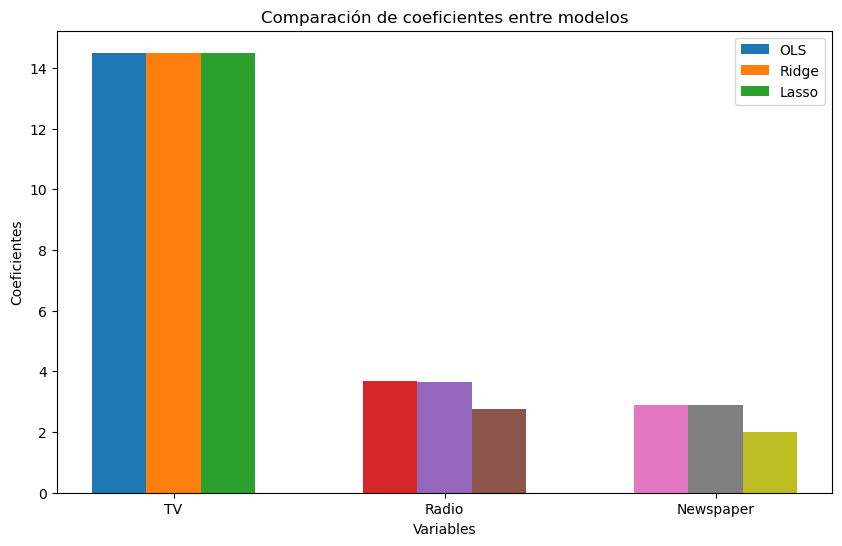

In [76]:
#Visualización de coeficientes
variables = ['TV', 'Radio', 'Newspaper']
resultados = resultados.reset_index(drop=True)
plt.figure(figsize=(10, 6))
for i, var in enumerate(variables):
    plt.bar(i - 0.2, resultados.loc[i, 'OLS Coef'], width=0.2, label='OLS' if i == 0 else "")
    plt.bar(i, resultados.loc[i, 'Ridge Coef'], width=0.2, label='Ridge' if i == 0 else "")
    plt.bar(i + 0.2, resultados.loc[i, 'Lasso Coef'], width=0.2, label='Lasso' if i == 0 else "")

plt.xticks(range(3), variables)
plt.xlabel('Variables')
plt.ylabel('Coeficientes')
plt.title('Comparación de coeficientes entre modelos')
plt.legend()
plt.show()


La gráfica muestra los coeficientes de los tres modelos (OLS, Ridge, Lasso) para cada variable predictora (TV, Radio, Newspaper).

TV:
- OLS tiene el coeficiente más alto.
- Ridge tiene un coeficiente ligeramente menor.
- Lasso tiene un coeficiente significativamente menor.

Radio:
- OLS tiene el coeficiente más alto.
- Ridge tiene un coeficiente ligeramente menor.
- Lasso tiene un coeficiente significativamente menor.

Newspaper:
- OLS y Ridge tienen coeficientes similares y relativamente bajos.
- Lasso reduce el coeficiente a cero, eliminando esta variable del modelo.

Ridge Regression:
Mantiene todas las variables pero reduce ligeramente los coeficientes, lo que ayuda a controlar la multicolinealidad y reduce el sobreajuste sin afectar significativamente el rendimiento del modelo.

Lasso Regression:
Realiza una selección de características al reducir algunos coeficientes a cero, lo que simplifica el modelo. En este caso, elimina la variable Newspaper, lo que sugiere que no contribuye significativamente a la predicción de las ventas.

OLS:
Proporciona el modelo más simple sin penalización.